# Methodological Foundation of a Numerical Taxonomy of Urban Form

This notebook serves as a template for morphometric assessment and generation of a taxonomy.

## Reproducible Python code to generate taxonomy

Complete morphometrics assessment from input data to taxonomy.

Input data:
 - building footprints
 - street network
 
This notebook is running the analysis on the sample of the data used in Prague case study. You can replace the sample with your own data, assuming that they are cleaned to a required standard. 

The sample is saved in `../files/sample.gpkg` with two layers named `buildings` and `streets`. `buildings` are Polygons, whilst `streets` are LineStrings.

Buildings data contain a single attribute column:

- `height` - building height in meters.

This notebook has been updated to work with `momepy` 0.5 and `geopandas` 0.10. The original work has been carried out using `momepy` 0.3 within the Docker container `darribas/gds_py:5.0`.

All data generated throughout the method are saved to files (unless commented out).

First we import all required libraries.

In [1]:
import warnings
import shapely
import math
from shapely.geometry import Polygon
from factor_analyzer import calculate_kmo,FactorAnalyzer
import geopandas as gpd
import libpysal
import mapclassify
import matplotlib.pyplot as plt
import momepy as mm
import numpy as np
import pandas as pd
import scipy as sp
import scipy.spatial.distance
import seaborn as sns
import factor_analyzer
from factor_analyzer.factor_analyzer import calculate_kmo,calculate_bartlett_sphericity
from tqdm.auto import tqdm
from sklearn import preprocessing
from sklearn.cluster import KMeans,DBSCAN,SpectralClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
# we are using bleeding edge software that emits some warnings irrelevant for the current runtime
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
warnings.filterwarnings('ignore', message='.*overflow encountered*')
warnings.filterwarnings('ignore', message='.*index_parts defaults to True')
warnings.filterwarnings('ignore', message='.*`op` parameter is deprecated*')

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check the input data

We load buildings and create unique ID.

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\plotting.py:937: UserWarning: Glyph 21382 (\N{CJK UNIFIED IDEOGRAPH-5386}) missing from current font.
  plt.draw()
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\plotting.py:937: UserWarning: Glyph 21490 (\N{CJK UNIFIED IDEOGRAPH-53F2}) missing from current font.
  plt.draw()
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\plotting.py:937: UserWarning: Glyph 39118 (\N{CJK UNIFIED IDEOGRAPH-98CE}) missing from current font.
  plt.draw()
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\plotting.py:937: UserWarning: Glyph 35980 (\N{CJK UNIFIED IDEOGRAPH-8C8C}) missing from current font.
  plt.draw()
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\plotting.py:937: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from current font.
  plt.draw()
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\plotting.py:937: UserWarning:

<AxesSubplot: >

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21382 (\N{CJK UNIFIED IDEOGRAPH-5386}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21490 (\N{CJK UNIFIED IDEOGRAPH-53F2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39118 (\N{CJK UNIFIED IDEOGRAPH-98CE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35980 (\N{CJK UNIFIED IDEOGRAPH-8C8C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6

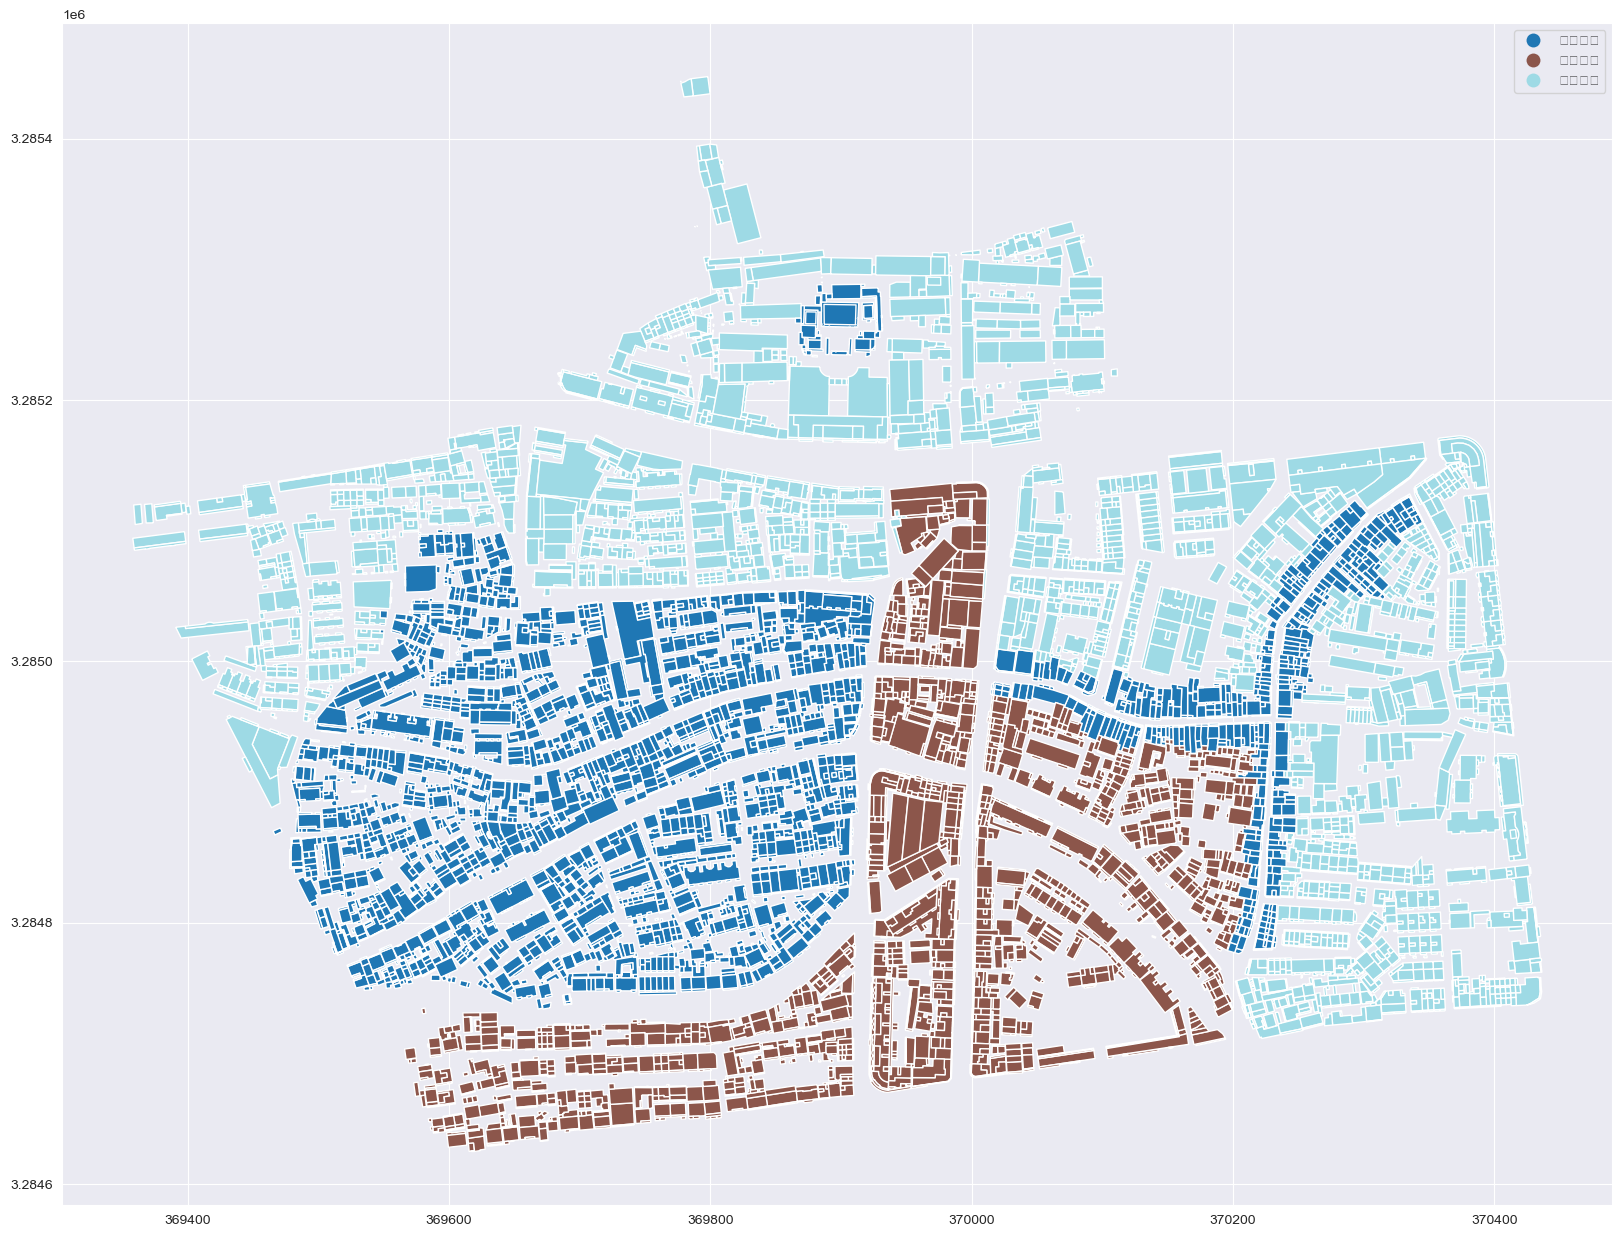

In [2]:
# 这是自己的模型
path = "../files/buildings_230221.shp"
buildings = gpd.read_file(path)
buildings=buildings.rename({'Elevation':'height','功能大':'功能','材质大':'材质','Text':'结构','建筑产':'产权','风貌分':'风貌','Shape_Leng':'Peri','Shape_Area':'Area'},axis=1)
buildings['height']=np.round(buildings['height'],2)
buildings_cate=buildings.loc[:,['功能','材质','结构','产权','风貌']]
buildings_morph=buildings.loc[:,['height','geometry','Area','Peri']]
buildings.plot('风貌', categorical=True, cmap='tab20', legend=True, figsize=(20, 20))

<AxesSubplot: >

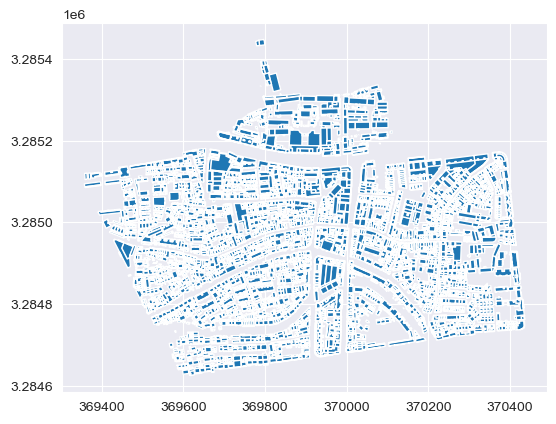

In [3]:
buildings.plot()

In [4]:
buildings_cate=pd.DataFrame(buildings_cate)
buildings_cate=pd.get_dummies(buildings_cate)
buildings_cate.drop(['产权_缺'],axis=1)
buildings_cate.corr()
buildings_cate

,功能_休闲娱乐,功能_公司企业,功能_其他,功能_医疗,功能_商业服务,功能_居住,功能_政府机构,功能_教育培训,功能_生活服务,功能_综合,...,结构_破,结构_砼,结构_简,产权_公,产权_公（居住）,产权_私,产权_缺,风貌_历史风貌,风貌_混合风貌,风貌_现代风貌
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
8759,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
8760,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
8761,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [5]:
pca=PCA(n_components=0.95)

buildings_cate_compressed=pca.fit_transform(buildings_cate)
buildings_cate_compressed=pd.DataFrame(buildings_cate_compressed)
feature_name_list=[]
for i in range(len(buildings_cate_compressed.columns)):
    feature_name_list.append(f'reduced_discrete_feature{i}')
buildings_cate_compressed.columns=feature_name_list
buildings_cate["uID"] = range(len(buildings))
buildings_cate_compressed


,reduced_discrete_feature0,reduced_discrete_feature1,reduced_discrete_feature2,reduced_discrete_feature3,reduced_discrete_feature4,reduced_discrete_feature5,reduced_discrete_feature6,reduced_discrete_feature7,reduced_discrete_feature8,reduced_discrete_feature9,reduced_discrete_feature10,reduced_discrete_feature11,reduced_discrete_feature12,reduced_discrete_feature13
0,0.890698,-0.338585,-0.499850,0.408265,-0.219762,-0.665351,-0.261288,0.316402,0.592912,-0.138838,0.168758,0.651846,0.177656,-0.026956
1,0.654726,-0.691101,-0.633159,-0.010392,-0.629510,-0.222515,-0.172761,0.234792,-0.030692,0.003194,0.004926,-0.021811,-0.055683,-0.030417
2,0.654726,-0.691101,-0.633159,-0.010392,-0.629510,-0.222515,-0.172761,0.234792,-0.030692,0.003194,0.004926,-0.021811,-0.055683,-0.030417
3,1.155259,-0.050975,0.070929,-0.306689,0.349614,-0.124780,-0.901634,0.172286,0.885774,0.187004,-0.498251,-0.354868,-0.116436,-0.048953
4,0.914760,-0.181650,-0.269048,0.717878,-0.096660,-0.778058,-0.478200,0.625613,-0.226449,-0.333078,-0.105302,-0.088029,-0.033018,-0.068459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,-0.229868,-1.175423,0.212760,0.000183,-0.288177,-0.444939,0.002757,-0.009804,-0.031696,-0.026756,0.058994,-0.008121,-0.013890,-0.002324
8759,1.160846,0.469700,0.331838,-0.208439,-0.456543,-0.530985,0.041093,0.162246,0.428103,-0.035365,0.078603,0.093229,0.035738,0.052303
8760,1.091457,0.062411,0.054139,0.087128,0.023714,-0.503773,-0.525870,0.203172,0.176036,0.861973,0.291289,0.596978,-0.007439,-0.159564
8761,0.365826,-0.937618,0.048482,0.741285,-0.490745,0.516450,0.123495,-0.168043,0.025019,-0.013624,0.040673,-0.012603,-0.031782,0.014288


In [6]:
buildings_morph

,height,geometry,Area,Peri
0,36.04,"POLYGON ((370400.424 3284751.245, 370396.487 3...",20.983157,18.527875
1,25.01,"POLYGON ((370393.185 3284753.601, 370393.152 3...",7.978135,11.342289
2,24.13,"POLYGON ((370390.849 3284754.973, 370390.748 3...",10.640654,13.777501
3,25.33,"POLYGON ((370207.977 3285052.966, 370215.201 3...",33.407532,25.039392
4,35.85,"POLYGON ((370427.056 3284772.087, 370435.130 3...",28.050720,23.289332
...,...,...,...,...
8758,25.25,"POLYGON ((369802.330 3284938.250, 369802.105 3...",2.457637,38.848440
8759,31.54,"POLYGON ((370046.951 3285133.092, 370039.380 3...",60.777762,104.634689
8760,31.54,"POLYGON ((370039.380 3285133.415, 370037.885 3...",12.520223,92.415464
8761,24.39,"POLYGON ((370158.624 3284713.808, 370157.490 3...",23.439950,155.602470


Let's create a persistent unique identifier for each building.

In [7]:
buildings_morph["uID"] = range(len(buildings))

### Generate additional morphometric elements

Before we can start morhometrics we have to generate additional elements - tessellation and tessellation based blocks.

#### Morphological tessellation

Check input for tessellation. If the input data is clean, the check will result in zeros. The data does not have to be 100% clean (all 0). For example `Split features` may not cause any issue. 

In [8]:
check = mm.CheckTessellationInput(buildings_morph,shrink=0.1)

Collapsed features  : 1
Split features      : 30
Overlapping features: 257


C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\preprocessing.py:387: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  over_rows = sorted(overlapping.origin.append(overlapping.dest).unique())


Generate tessellation limited to 100 m buffer. Beware, it is memory demanding.

**Note:** You may find that this step requires more memory that you are able to provide. In that case, you may consider using an [enclosed tessellation](http://docs.momepy.org/en/stable/user_guide/elements/enclosed.html) method instead. However, that would require minor adaptation of the code below as well.

In [9]:
limit = mm.buffered_limit(buildings_morph, 10)

tessellation = mm.Tessellation(buildings_morph, "uID", limit, verbose=False,shrink=0.1)
tessellation = tessellation.tessellation

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\elements.py:277: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  objects.loc[mask, objects.geometry.name] = objects[mask].buffer(
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\tools\clip.py:48: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\elements.py:383: UserWarning: Tessellation does not fully match buildings. 8 element(s) collapsed during generation - unique_id: {5384, 8356, 8357, 8297, 8172,

In [10]:
tessellation

,uID,geometry
7270,7271,"POLYGON ((369793.853 3284649.426, 369794.233 3..."
7269,7270,"POLYGON ((369804.799 3284651.119, 369804.818 3..."
7306,7307,"POLYGON ((369826.178 3284648.119, 369826.448 3..."
7318,7319,"POLYGON ((369870.380 3284663.523, 369870.431 3..."
2320,2320,"POLYGON ((369843.633 3284660.186, 369843.527 3..."
...,...,...
8207,8210,"POLYGON ((369906.886 3285292.237, 369906.797 3..."
8380,8388,"POLYGON ((369986.871 3285306.343, 369986.707 3..."
8630,8638,"POLYGON ((369983.162 3285295.586, 369982.742 3..."
8208,8211,"POLYGON ((369949.499 3285292.687, 369949.088 3..."


<AxesSubplot: >

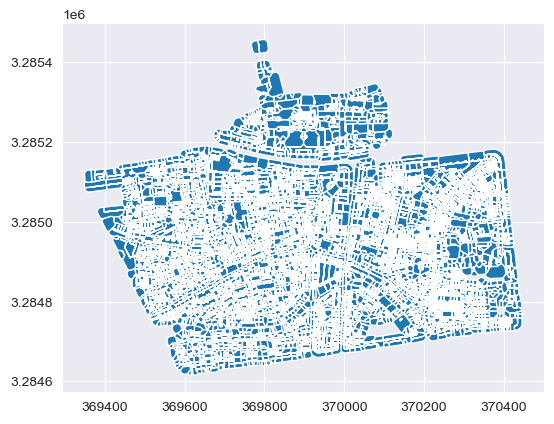

In [11]:
tessellation.plot()

We save tessellation to file. Note that this file is not part of the repository but can be fully created using the input sample and this notebook.

In [12]:
tessellation.to_file("../files/geometry.gpkg", layer="tessellation")

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Tessellation based blocks

To generate tessellation based blocks we also need street network, therefore we need to read it to GeoDataFrame first.

In [13]:
path = "../files/streets.shp"
streets = gpd.read_file(path)
streets=gpd.GeoDataFrame(streets['geometry'])

In [14]:
streets

,geometry
0,"LINESTRING (369748.161 3284121.735, 369586.261..."
1,"LINESTRING (370165.482 3285171.342, 370155.930..."
2,"LINESTRING (368408.136 3284728.424, 369303.340..."
3,"LINESTRING (370409.997 3285199.176, 370488.402..."
4,"LINESTRING (370334.225 3285134.783, 370345.756..."
...,...
91,"LINESTRING (369772.377 3284779.055, 369784.453..."
92,"LINESTRING (369650.954 3285034.888, 369657.080..."
93,"LINESTRING (369988.226 3285150.391, 369986.667..."
94,"LINESTRING (369817.604 3285323.260, 369886.863..."


<AxesSubplot: >

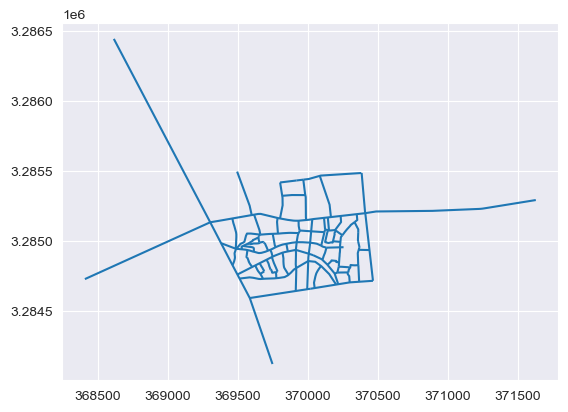

In [15]:
streets.plot()

To create blocks within the full `limit`, it is always safer to extend street network to the edge of the limit.

In [16]:
extended = mm.extend_lines(streets, tolerance=120, target=gpd.GeoSeries([limit.boundary]), barrier=buildings)

In [17]:
blocks = mm.Blocks(tessellation, edges=extended, buildings=buildings_morph, id_name='bID', unique_id='uID')
blocks_df = blocks.blocks  # get blocks df
buildings_morph['bID'] = blocks.buildings_id.values  # get block ID
tessellation['bID'] = blocks.tessellation_id.values  # get block ID
blocks_df

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\momepy\elements.py:631: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4509
Right CRS: None

  cut = gpd.overlay(
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\libpysal\weights\_contW_lists.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(list(zip(*shape.coords.xy)) for shape in shape)))


,bID,geometry
0,0,"POLYGON ((369618.879 3284614.731, 369618.643 3..."
1,1,"POLYGON ((369955.278 3284663.024, 369939.975 3..."
2,2,"POLYGON ((370004.758 3284671.310, 370004.416 3..."
3,3,"POLYGON ((370157.567 3284694.868, 370156.477 3..."
4,4,"POLYGON ((369854.266 3284770.656, 369854.173 3..."
5,5,"POLYGON ((369775.777 3284747.192, 369775.854 3..."
6,6,"POLYGON ((369780.398 3284785.309, 369780.287 3..."
7,7,"POLYGON ((369856.023 3284768.140, 369855.627 3..."
8,8,"POLYGON ((369911.530 3284811.235, 369911.628 3..."
9,9,"POLYGON ((370223.149 3284701.286, 370222.161 3..."


#### Link streets

We need to understand which building belongs to which street segment. We link IDs together based on proximity.

In [18]:
streets["nID"] = range(len(streets))
buildings_morph['nID'] = mm.get_network_id(buildings, streets, 'nID', min_size=300, verbose=False)
tessellation = tessellation.merge(buildings_morph[['uID', 'nID']], on='uID', how='left')

Finally, we save elements to a file.

In [19]:
path = '../files/geometry.gpkg'
tessellation.to_file(path, layer='tessellation', driver='GPKG')
buildings_morph.to_file(path, layer='buildings', driver='GPKG')
blocks_df.to_file(path, layer='blocks', driver='GPKG')

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Measure primary characters

This part measures 74 primary morphometric characters.

It does save intermediate parquet files as a backup.

In [20]:
def _azimuth(point1, point2):
    angle = np.arctan2(point2[0] - point1[0], point2[1] - point1[1])
    return np.degrees(angle) if angle > 0 else np.degrees(angle) + 180


def _dist(a, b):
    return math.hypot(b[0] - a[0], b[1] - a[1])

In [21]:
blocks = blocks_df
blocks_df

,bID,geometry
0,0,"POLYGON ((369618.879 3284614.731, 369618.643 3..."
1,1,"POLYGON ((369955.278 3284663.024, 369939.975 3..."
2,2,"POLYGON ((370004.758 3284671.310, 370004.416 3..."
3,3,"POLYGON ((370157.567 3284694.868, 370156.477 3..."
4,4,"POLYGON ((369854.266 3284770.656, 369854.173 3..."
5,5,"POLYGON ((369775.777 3284747.192, 369775.854 3..."
6,6,"POLYGON ((369780.398 3284785.309, 369780.287 3..."
7,7,"POLYGON ((369856.023 3284768.140, 369855.627 3..."
8,8,"POLYGON ((369911.530 3284811.235, 369911.628 3..."
9,9,"POLYGON ((370223.149 3284701.286, 370222.161 3..."


In [22]:
buildings_morph

,height,geometry,Area,Peri,uID,bID,nID
0,36.04,"POLYGON ((370400.424 3284751.245, 370396.487 3...",20.983157,18.527875,0,12,50
1,25.01,"POLYGON ((370393.185 3284753.601, 370393.152 3...",7.978135,11.342289,1,12,50
2,24.13,"POLYGON ((370390.849 3284754.973, 370390.748 3...",10.640654,13.777501,2,12,50
3,25.33,"POLYGON ((370207.977 3285052.966, 370215.201 3...",33.407532,25.039392,3,24,27
4,35.85,"POLYGON ((370427.056 3284772.087, 370435.130 3...",28.050720,23.289332,4,12,62
...,...,...,...,...,...,...,...
8758,25.25,"POLYGON ((369802.330 3284938.250, 369802.105 3...",2.457637,38.848440,8758,29,73
8759,31.54,"POLYGON ((370046.951 3285133.092, 370039.380 3...",60.777762,104.634689,8759,41,65
8760,31.54,"POLYGON ((370039.380 3285133.415, 370037.885 3...",12.520223,92.415464,8760,41,65
8761,24.39,"POLYGON ((370158.624 3284713.808, 370157.490 3...",23.439950,155.602470,8761,3,59


Note: 

- `height` is building height in meters. If you do not have it, skip affected lines.

In [23]:
buildings_morph['floor_area'] = (buildings_morph["height"] / 3.5) * buildings_morph['Area']
buildings_box=gpd.GeoDataFrame()
rect_area_list=[]
rect_peri_list=[]
rect_ori_list=[]
for geom in tqdm(buildings_morph.geometry):
    polygon=Polygon(geom)
    min_rect=polygon.minimum_rotated_rectangle
    bbox = list(min_rect.exterior.coords)
    axis1 = _dist(bbox[0], bbox[3])
    axis2 = _dist(bbox[0], bbox[1])

    if axis1 <= axis2:
        az = _azimuth(bbox[0], bbox[1])
    else:
        az = _azimuth(bbox[0], bbox[3])
    rect_ori_list.append(az)
    rect_area_list.append(geom.area)
    rect_peri_list.append(geom.length)
buildings_morph['Ori']=rect_ori_list
buildings_box['Area']=rect_area_list
buildings_box['Peri']=rect_peri_list

100%|██████████| 8763/8763 [00:04<00:00, 2069.67it/s]


In [24]:
buildings_box['MBG_L']=(buildings_box['Peri']+np.sqrt(np.square(buildings_box['Peri'])-16*buildings_box['Area']))/4
buildings_box['MBG_W']=buildings_box['Area']/buildings_box['MBG_L']

buildings_morph['MBG_L']=buildings_box['MBG_L']
buildings_morph['MBG_W']=buildings_box['MBG_W']
buildings_morph['REC_A']=buildings_morph['Area']/buildings_box['Area']
buildings_morph['REC_P']=buildings_morph['Peri']/buildings_box['Peri']
buildings_morph

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,height,geometry,Area,Peri,uID,bID,nID,floor_area,Ori,MBG_L,MBG_W,REC_A,REC_P
0,36.04,"POLYGON ((370400.424 3284751.245, 370396.487 3...",20.983157,18.527875,0,12,50,216.066568,176.860958,5.319076,3.944887,1.0,0.999997
1,25.01,"POLYGON ((370393.185 3284753.601, 370393.152 3...",7.978135,11.342289,1,12,50,57.009471,86.814469,3.084944,2.586152,1.0,1.000009
2,24.13,"POLYGON ((370390.849 3284754.973, 370390.748 3...",10.640654,13.777501,2,12,50,73.359708,178.728457,4.550246,2.338479,1.0,1.000004
3,25.33,"POLYGON ((370207.977 3285052.966, 370215.201 3...",33.407532,25.039392,3,24,27,241.775085,125.225564,8.663535,3.856109,1.0,1.000004
4,35.85,"POLYGON ((370427.056 3284772.087, 370435.130 3...",28.050720,23.289332,4,12,62,287.319520,83.673016,8.240712,3.403919,1.0,1.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,25.25,"POLYGON ((369802.330 3284938.250, 369802.105 3...",2.457637,38.848440,8758,29,73,17.730092,67.575236,4.523013,0.543363,1.0,3.833948
8759,31.54,"POLYGON ((370046.951 3285133.092, 370039.380 3...",60.777762,104.634689,8759,41,65,547.694464,2.444460,8.548180,7.110024,1.0,3.341210
8760,31.54,"POLYGON ((370039.380 3285133.415, 370037.885 3...",12.520223,92.415464,8760,41,65,112.825094,4.276622,8.566260,1.461574,1.0,4.607947
8761,24.39,"POLYGON ((370158.624 3284713.808, 370157.490 3...",23.439950,155.602470,8761,3,59,163.342969,165.182604,19.866047,1.179900,1.0,3.696733


In [25]:

tessellation['stcOri'] = mm.Orientation(tessellation, verbose=False).series


In [26]:
blocks["blcArea"] = mm.Area(blocks).series
blocks

,bID,geometry,blcArea
0,0,"POLYGON ((369618.879 3284614.731, 369618.643 3...",37464.250256
1,1,"POLYGON ((369955.278 3284663.024, 369939.975 3...",12463.783213
2,2,"POLYGON ((370004.758 3284671.310, 370004.416 3...",13012.283440
3,3,"POLYGON ((370157.567 3284694.868, 370156.477 3...",10034.418604
4,4,"POLYGON ((369854.266 3284770.656, 369854.173 3...",11677.409585
5,5,"POLYGON ((369775.777 3284747.192, 369775.854 3...",8886.894978
6,6,"POLYGON ((369780.398 3284785.309, 369780.287 3...",4143.334534
7,7,"POLYGON ((369856.023 3284768.140, 369855.627 3...",12891.798608
8,8,"POLYGON ((369911.530 3284811.235, 369911.628 3...",7965.016120
9,9,"POLYGON ((370223.149 3284701.286, 370222.161 3...",6243.179430


In [27]:
buildings_morph=buildings_morph.drop(['blcArea_x','blcArea_y'],axis=1)
buildings_morph=buildings_morph.merge(blocks.drop(columns='geometry'), on='bID', how='left')
buildings_morph['Far']=buildings_morph['floor_area']/buildings_morph['blcArea']
buildings_morph['BD']=buildings_morph['Area']/buildings_morph['blcArea']


KeyError: "['blcArea_x', 'blcArea_y'] not found in axis"

In [ ]:
buildings_morph

Save data to parquets as a checkpoint backup.

In [ ]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings_morph.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
blocks.drop(columns='geometry').to_parquet('../files/blocks_data.parquet')

In [ ]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)
blo_q1 = libpysal.weights.contiguity.Queen.from_dataframe(blocks, ids="bID", silence_warnings=True)
queen_3 = mm.sw_high(k=3, weights=queen_1)
buildings_morph['ltbIBD'] = mm.MeanInterbuildingDistance(buildings_morph, queen_1, 'uID', queen_3, verbose=False).series
buildings_morph['ltcBuA'] = mm.BuildingAdjacency(buildings_morph, queen_3, 'uID', buildings_q1, verbose=False).series
buildings_morph

In [ ]:
tessellation = tessellation.merge(buildings[['floor_area', 'uID']], on='uID', how='left')
tessellation['licGDe'] = mm.Density(tessellation, 'floor_area', queen_3, 'uID', 'sdcAre').series
tessellation = tessellation.drop(columns='floor_area')
tessellation['ltcWRB'] = mm.BlocksCount(tessellation, 'bID', queen_3, 'uID', verbose=False).series
tessellation['sicCAR'] = mm.AreaRatio(tessellation, buildings, 'sdcAre', 'sdbAre', 'uID').series
tessellation['sicFAR'] = mm.AreaRatio(tessellation, buildings, 'sdcAre', 'floor_area', 'uID').series

In [ ]:
tessellation

Save data to parquets and spatial weights matrices to gal files.

In [ ]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
 
fo = libpysal.io.open('../files/queen_1.gal', 'w')
fo.write(queen_1)
fo.close()
 
fo = libpysal.io.open('../files/queen_3.gal', 'w')
fo.write(queen_3)
fo.close()
 
fo = libpysal.io.open('../files/buildings_q1.gal', 'w')
fo.write(buildings_q1)
fo.close()

In [ ]:
streets["sdsLen"] = mm.Perimeter(streets).series
tessellation["stcSAl"] = mm.StreetAlignment(tessellation, streets, "stcOri", "nID").series
buildings["stbSAl"] = mm.StreetAlignment(buildings, streets, "stbOri", "nID").series

In [ ]:
profile = mm.StreetProfile(streets, buildings_morph, heights='height', distance=3)
streets["sdsSPW"] = profile.w
streets["sdsSPH"] = profile.h
streets["sdsSPR"] = profile.p
streets["sdsSPO"] = profile.o
streets["sdsSWD"] = profile.wd
streets["sdsSHD"] = profile.hd

In [ ]:
streets["sssLin"] = mm.Linearity(streets).series
streets["sdsAre"] = mm.Reached(streets, tessellation, "nID", "nID", mode="sum", values="sdcAre").series
streets["sisBpM"] = mm.Count(streets, buildings, "nID", "nID", weighted=True).series

In [ ]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
streets.drop(columns='geometry').to_parquet('../files/streets_data.parquet')

In [ ]:
str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(streets, silence_warnings=True)
 
streets["misRea"] = mm.Reached(
    streets, tessellation, "nID", "nID", spatial_weights=str_q1, mode="count", verbose=False
).series
streets["mdsAre"] = mm.Reached(streets, tessellation, "nID", "nID", spatial_weights=str_q1,
                               mode="sum", verbose=False).series

In [ ]:
graph = mm.gdf_to_nx(streets)
graph = mm.node_degree(graph)
graph = mm.subgraph(
    graph,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len", 
    verbose=False
)
graph = mm.cds_length(graph, radius=3, name="ldsCDL", verbose=False)
graph = mm.clustering(graph, name="xcnSCl")
graph = mm.mean_node_dist(graph, name="mtdMDi", verbose=False)
 
nodes, edges, sw = mm.nx_to_gdf(graph, spatial_weights=True)

In [ ]:
nodes.to_file(path, layer="nodes", driver="GPKG")
edges.to_file(path, layer="edges", driver="GPKG")
 
fo = libpysal.io.open("../files/nodes.gal", "w")
fo.write(sw)
fo.close()

In [ ]:
edges_w3 = mm.sw_high(k=3, gdf=edges)
edges["ldsMSL"] = mm.SegmentsLength(edges, spatial_weights=edges_w3, mean=True, verbose=False).series
 
edges["ldsRea"] = mm.Reached(edges, tessellation, "nID", "nID", spatial_weights=edges_w3, verbose=False).series
edges["ldsRea"] = mm.Reached(
    edges, tessellation, "nID", "nID", spatial_weights=edges_w3, mode="sum", values="sdcAre", verbose=False
).series
 
nodes_w5 = mm.sw_high(k=5, weights=sw)
nodes["lddNDe"] = mm.NodeDensity(nodes, edges, nodes_w5, verbose=False).series
nodes["linWID"] = mm.NodeDensity(
    nodes, edges, nodes_w5, weighted=True, node_degree="degree", verbose=False
).series
 
buildings["nodeID"] = mm.get_node_id(buildings, nodes, edges, "nodeID", "nID")
tessellation = tessellation.merge(buildings[["uID", "nodeID"]], on="uID", how="left")
 
nodes_w3 = mm.sw_high(k=3, weights=sw)
 
nodes["lddRea"] = mm.Reached(nodes, tessellation, "nodeID", "nodeID", nodes_w3, verbose=False).series
nodes["lddARe"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", nodes_w3, mode="sum", values="sdcAre", verbose=False
).series
 
nodes["sddAre"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", mode="sum", values="sdcAre", verbose=False
).series
nodes["midRea"] = mm.Reached(nodes, tessellation, "nodeID", "nodeID", spatial_weights=sw, verbose=False).series
nodes["midAre"] = mm.Reached(
    nodes, tessellation, "nodeID", "nodeID", spatial_weights=sw, mode="sum", values="sdcAre", verbose=False
).series
 
nodes.rename(
    columns={
        "degree": "mtdDeg",
        "meshedness": "lcdMes",
        "local_closeness": "lcnClo",
        "proportion_3": "linP3W",
        "proportion_4": "linP4W",
        "proportion_0": "linPDE",
    }, inplace=True
)

In [ ]:
tessellation.drop(columns='geometry').to_parquet('../files/tess_data.parquet')
buildings.drop(columns='geometry').to_parquet('../files/buildings_data.parquet')
nodes.drop(columns='geometry').to_parquet('../files/nodes_data.parquet')
edges.drop(columns='geometry').to_parquet('../files/edges_data.parquet')

In [ ]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'bID', 'nodeID', 'geometry']), on='uID')
merged = merged.merge(blocks.drop(columns='geometry'), on='bID', how='left')
merged = merged.merge(edges.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

Clean columns to keep only measured data.

In [ ]:
primary = merged.drop(columns=['nID', 'bID', 'nodeID', 'mm_len', 'cdsbool', 
                               'node_start', 'node_end', 'geometry', 'floor_area'
                               ])

In [ ]:
primary.to_parquet('../files/primary.parquet')

## Measure contextual - spatially lagged characters

This part measures contextual characters.

In [ ]:
primary

In [ ]:
gdf = primary.set_index('uID')
spatial_weights = queen_3
unique_id = 'uID'

In [ ]:
gdf

In [ ]:
df=pd.DataFrame(gdf)
df=df.loc[:,(df!=0).any(axis=0)]
features=df.columns
unique_id=df.index
df = df.replace(np.inf, np.nan).fillna(0)
kmo=calculate_kmo(df)
print(kmo)
chi,p=calculate_bartlett_sphericity(df)
print(chi,np.round(p,5))
fa=FactorAnalyzer(71,rotation=None)
fa.fit(df)


In [ ]:
ev,v=fa.get_eigenvalues()
var=fa.get_factor_variance()
ev

In [ ]:
var[2]

In [ ]:
fa_rotate = FactorAnalyzer(16, rotation='varimax', method='principal')
fa_rotate.fit(df)
df_loadings=pd.DataFrame(fa_rotate.loadings_,index=features)
df_loadings

In [ ]:
factor_score = fa_rotate.transform(df)
gdf=gpd.GeoDataFrame(factor_score,index=unique_id)
feature_name_list=list()
for i in range(len(gdf.columns)):
    feature_name_list.append(f'factor_{i}')
gdf.columns=feature_name_list
gdf


In [ ]:
plt.figure(figsize=(14,14))
ax=sns.heatmap(gdf.corr(),annot=True)
ax.set_xticklabels(rotation=0)
plt.show()

In [ ]:
gdf = gdf.replace(np.inf, np.nan).fillna(0)  # normally does not happen, but to be sure
chars = gdf.columns

In [ ]:
means = {}
ranges = {}
theils = {}
simpsons = {}

for ch in gdf.columns:
    means[ch] = []
    ranges[ch] = []
    theils[ch] = []
    simpsons[ch] = []

Resolve potential missingness cause by invalid input data. That was not case in the presented case studies but may be case in subsequent research.

In [ ]:
gdf = gdf.replace(np.inf, np.nan).fillna(0)  # normally does not happen, but to be sure
chars = gdf.columns
chars

In [ ]:
gdf['lcdMes'] = gdf.apply(
            lambda row: row.lcdMes if row.lcdMes >= 0 else 0,
            axis=1,
        )  # normally does not happen, but to be sure

Define Theil and Simpson functions.

In [ ]:
def _theil(y):
    y = np.array(y)
    n = len(y)
    plus = y + np.finfo('float').tiny * (y == 0)  # can't have 0 values
    yt = plus.sum(axis=0)
    s = plus / (yt * 1.0)
    lns = np.log(n * s)
    slns = s * lns
    t = sum(slns)
    return t

In [ ]:
def _simpson_di(data):

    def p(n, N):
        if n == 0:
            return 0
        return float(n) / N

    N = sum(data.values())

    return sum(p(n, N) ** 2 for n in data.values() if n != 0)

Skewness is used as an estimation of the distribution. Extremely skewed use HeadTail breaks for Simpson's binning, other Natural Breaks.

In [ ]:
skewness = pd.DataFrame(index=chars)
for c in chars:
    skewness.loc[c, 'skewness'] = sp.stats.skew(gdf[c])
headtail = list(skewness.loc[skewness.skewness >= 1].index)
to_invert = skewness.loc[skewness.skewness <= -1].index

for inv in to_invert:
    gdf[inv + '_r'] = gdf[inv].max() - gdf[inv]
inverted = [x for x in gdf.columns if '_r' in x]
headtail = headtail + inverted
natural = [x for x in chars if x not in headtail]

In [ ]:
bins = {}
for c in headtail:
    bins[c] = mapclassify.HeadTailBreaks(gdf[c]).bins
for c in natural:
    bins[c] = mapclassify.gadf(gdf[c], method='NaturalBreaks')[1].bins

Loop over DataFrame and measure IQM, IQR, IDT and Simpson.

In [ ]:
print(type(spatial_weights.neighbors))
print(spatial_weights.neighbors.keys())

In [ ]:
# 因为有些buildings丢失了，所以只能在现在存在的buildings索引上跑一遍
index_list=list(gdf.index.values)
for index in tqdm(index_list, total=gdf.shape[0]):
    neighbours = [index]
    neighbours += spatial_weights.neighbors[index]  
    subset = gdf.loc[neighbours]
    for ch in chars:
        values_list = subset[ch] 
        idec = mm.limit_range(values_list, rng=(10, 90))
        iquar = mm.limit_range(values_list, rng=(25, 75))
        
        means[ch].append(np.mean(iquar))
        ranges[ch].append(max(iquar) - min(iquar))
        # theils[ch].append(_theil(idec))
        
        # sample_bins = mapclassify.UserDefined(values_list, list(bins[ch]))
        # counts = dict(zip(bins[ch], sample_bins.counts))
        # simpsons[ch].append(_simpson_di(counts))

In [ ]:
contextual = {}
for ch in chars:
    contextual[ch + '_meanIQ3'] = means[ch]
    contextual[ch + '_rangeIQ3'] = ranges[ch]
    # contextual[ch + '_theilID3'] = theils[ch]
    # contextual[ch + '_simpson'] = simpsons[ch]

contextual = pd.DataFrame(contextual, index=gdf.index)

In [ ]:
contextual.shape

In [ ]:
contextual.to_parquet('../files/contextual.parquet')

## Clustering

We use contextual characters to do GMM clustering.

In [ ]:

contextual

In [ ]:
data = contextual.copy()

First we standardize data.

In [ ]:
# normalise data
x = data.values
scaler = preprocessing.StandardScaler()
cols = list(data.columns)
data[cols] = scaler.fit_transform(data[cols])
data


In [ ]:
data_new=data.fillna(data.mean())
data_new=data_new.loc[:,(data_new!=0).any(axis=0)]
kmo=calculate_kmo(data_new)

chi,p=calculate_bartlett_sphericity(data_new)
# print(chi,np.round(p,5))
fa=FactorAnalyzer(80,rotation=None)
fa.fit(data_new)


In [ ]:
print(kmo[1])
print(p)

In [ ]:
ev,v=fa.get_eigenvalues()
var=fa.get_factor_variance()
ev
# print(var[2])

In [ ]:
fa_rotate=FactorAnalyzer(57,rotation='varimax',method='principal')
fa_rotate.fit(data_new)

In [ ]:
fa_rotate.loadings_

In [ ]:
factor_score=fa_rotate.transform(data_new)
factor_score

In [ ]:
pca = PCA(n_components=0.95)
data=data.fillna(data.mean())
data_new=pca.fit_transform(data)
pca.explained_variance_ratio_

In [ ]:
data_new=data
data_new

# K-Means

In [ ]:
# specify how many times should each option be tried (more better, but takes a long time)

In [ ]:

distance_list=list()
k_list=list()
score_list=list()
for k in range(2,20):
    km=KMeans(n_clusters=k)
    km.fit(data_new)
    k_list.append(k)
    distance_list.append(km.inertia_)
    score_list.append(silhouette_score(data_new,km.labels_))


In [ ]:
plt.plot(k_list,distance_list)

In [ ]:
plt.plot(k_list,score_list)

In [ ]:
km=KMeans(n_clusters=5)
km.fit(data_new)
labels_km=km.predict(data_new)

pd.Series(labels_km, index=data.index).to_csv('../files/cluster_labels_km.csv')


In [ ]:
group = data.groupby(labels_km).mean()
Z = hierarchy.linkage(group, 'ward')
plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Z, labels=group.index)


In [ ]:
buildings.loc[index_list].plot(labels_km, categorical=True, cmap='tab20', legend=True, figsize=(20, 20))

In [ ]:
data_new
# labels_km=pd.DataFrame(labels_km,index=unique_id)
# labels_km
# data_new['labels']=labels_km[0]

In [ ]:
data_new=pd.DataFrame(data_new)
# data_new=data_new.drop(['labels','distance'],axis=1)
labels_km=pd.DataFrame(labels_km,index=unique_id)
centerpoints=km.cluster_centers_
data_new


In [ ]:
for d_index,d_row in data_new.iterrows():
    label=labels_km.loc[d_index][0]
    distance=sp.spatial.distance.euclidean(d_row.values,centerpoints[label])
    data_new.loc[d_index,'distance']=distance

data_new['labels']=labels_km[0]
data_prototype=data_new.groupby(['labels'])['distance'].idxmin()
data_prototype

In [ ]:
bic = pd.DataFrame(columns=['n', 'bic', 'run'])
ix = 0

n_components_range = range(2,20) # specify range you want to assess. 2-8 is sensible for the sample, not the whole city
gmmruns = 5
data = data.fillna(0)
for n_components in n_components_range:
    for i in range(gmmruns):
        gmm = GaussianMixture(n_components=n_components, covariance_type="full", max_iter=200, n_init=1, verbose=1)
        fitted = gmm.fit(data)
        bicnum = gmm.bic(data)
        bic.loc[ix] = [n_components, bicnum, i]
        ix += 1

        print(n_components, i, "BIC:", bicnum)

In [ ]:
bic.to_csv('../files/complete_BIC.csv')

Based on the plot below, we estimate the optimal `n` either based on the elbow of the curve or as the minimum.

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.lineplot(ax=ax, x='n', y='bic', data=bic)
# plt.savefig('../files/complete_BIC.pdf')

### Gaussian Mixture Model

In [ ]:
n1 = 6  # illustrative - always base the number on a reasonable estimation of the optimal number of components
n_init1 = 10 # more initialization, more stable clustering gets

n2 = 5  # illustrative - always base the number on a reasonable estimation of the optimal number of components
n_init2 = 10  # more initialization, more stable clustering gets

# 分6类
gmm1 = GaussianMixture(n_components=n1, covariance_type="full", max_iter=200, n_init=n_init1, verbose=1)
# 分5类
gmm2 = GaussianMixture(n_components=n2, covariance_type="full", max_iter=200, n_init=n_init2, verbose=1)

fitted1 = gmm1.fit(data)
fitted2 = gmm2.fit(data)

In [ ]:
labels1 = gmm1.predict(data)
labels2 = gmm2.predict(data)

In [ ]:
pd.Series(labels1, index=data.index).to_csv('../files/cluster_labels1_gmm.csv')
pd.Series(labels2, index=data.index).to_csv('../files/cluster_labels2_gmm.csv')

#### Hierachical clustering

Finally, we create hierarchical classification - taxonomy.

In [ ]:
# 分6类
group = data.groupby(labels1).mean()
Z = hierarchy.linkage(group, 'ward')
plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Z, labels=group.index)

# plt.savefig('tree.pdf')

In [ ]:
# 分5类
group = data.groupby(labels2).mean()
Z = hierarchy.linkage(group, 'ward')
plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Z, labels=group.index)

# plt.savefig('tree.pdf')

## Results

In [ ]:
# 分6类
buildings.loc[index_list].plot(labels1, categorical=True, cmap='tab20', legend=True, figsize=(20, 20))

In [ ]:
# 分5类
buildings.loc[index_list].plot(labels2, categorical=True, cmap='tab20', legend=True, figsize=(20, 20))